# Homework 3

# Part 1: Email spam classification [50 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `HW2-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.

### Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [1]:
import numpy as np
import os
import glob
os.chdir('/Users/michellehsu/Desktop/CMU/Spring 2018/Mini 4/95-865 Unstructured Data Analytics/HW/HW 3 -Classification, Image Segmentation and Sentiment Analysis/HW2-data')
ham_filename = glob.glob('./ham/*.txt')
spam_filename = glob.glob('./spam/*.txt')
print("The number of ham email is",len(ham_filename))
print("The number of spam email is",len(spam_filename)) 

The number of ham email is 1500
The number of spam email is 3671


The dataset is imbalanced since the spam email(3674) accounts for 71% of the total training data(5174). Imbalanced dataset can cause problem when calculating the accuracy rate since the model will simply learn the distribution of the imbalanced data and yield result with high but biased accuracy.<br>
In order to overcome the imbalanced data, there are several ways to try.
1. Try to collect more data. However, it might incur additional cost.
2. Oversample the minority class and undersample the majority class, i.e. SMOTE
3. Evaluate the model with different metrics, instead of only looking at accuracy rate. 

### Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
os.chdir('/Users/michellehsu/Desktop/CMU/Spring 2018/Mini 4/95-865 Unstructured Data Analytics/HW/HW 3 -Classification, Image Segmentation and Sentiment Analysis/HW2-data/ham')
ham = []
for i in os.listdir(os.getcwd()):
    ham.append(makeWordList(i))

In [4]:
os.chdir('/Users/michellehsu/Desktop/CMU/Spring 2018/Mini 4/95-865 Unstructured Data Analytics/HW/HW 3 -Classification, Image Segmentation and Sentiment Analysis/HW2-data/spam')
spam = []
for i in os.listdir(os.getcwd()):
    spam.append(makeWordList(i))

In [5]:
email = []
email.extend(spam)
email.extend(ham)
labels = [1] * len(spam) + [0] * len(ham)

### Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=50, stop_words='english')

In [7]:
X = tf_vectorizer.fit_transform(email)
print("Vocabulary size:", len(tf_vectorizer.get_feature_names()))

Vocabulary size: 1680


### k-NN, Bernoulli Naive Bayes, SVM: Hyperparameter selection [20 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric.

   - k-NN: Select `k` from a range of values of your choice.
   - Bernoulli Naive Bayes: Use Laplace smoothing and select the smoothing parameter `alpha` from a range of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.

Store each chosen hyperparameter as `best_k`, `best_alpha` and `best_C` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [8]:
labels = np.array(labels)

In [9]:
#k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
num_folds = 5
indices = range(len(email))
k_fold = KFold(n_splits = num_folds, shuffle=True, random_state=95865)
k_values = list(range(2,11))
arg_max = None
max_cross_val_score = -np.inf
for k in k_values:
    fold_scores = []
    for train_indices, val_indices in k_fold.split(indices):
        classifier = KNeighborsClassifier(n_neighbors= k)
        classifier.fit(X[train_indices,],labels[train_indices, ])
        predicted_val_labels = classifier.predict(X[val_indices,])
        score = np.mean(f1_score(labels[val_indices,], predicted_val_labels, average='weighted'))
        fold_scores.append(score)
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = k
best_k = arg_max
print(best_k)

2


In [10]:
#Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
alpha_values = list(np.linspace(0.001, 2, 100))
arg_max = None
max_cross_val_score = -np.inf
for alpha in alpha_values:
    fold_scores = []
    for train_indices, val_indices in k_fold.split(indices):
        classifier = BernoulliNB(alpha= alpha)
        classifier.fit(X[train_indices,],labels[train_indices, ])
        predicted_val_labels = classifier.predict(X[val_indices,])
        score = np.mean(f1_score(labels[val_indices,], predicted_val_labels, average='weighted'))
        fold_scores.append(score)
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = alpha
best_alpha = arg_max
print(best_alpha)

0.0211919191919


In [11]:
#SVM
from sklearn import svm
param_values = np.logspace(-4, 2, 3)
arg_max = None
max_cross_val_score = -np.inf
for C in param_values:
    fold_scores = []
    for train_indices, val_indices in k_fold.split(indices):
        classifier = svm.SVC(C=C)
        classifier.fit(X[train_indices,],labels[train_indices, ])
        predicted_val_labels = classifier.predict(X[val_indices,])
        score = np.mean(f1_score(labels[val_indices,], predicted_val_labels, average='weighted'))
        fold_scores.append(score)
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > max_cross_val_score:
        max_cross_val_score = cross_val_score
        arg_max = C
            
best_C = arg_max
print(best_C)

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


100.0


## Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [12]:
#Read the test data
os.chdir('/Users/michellehsu/Desktop/CMU/Spring 2018/Mini 4/95-865 Unstructured Data Analytics/HW/HW 3 -Classification, Image Segmentation and Sentiment Analysis/HW2-data/testing')
test = []
for i in os.listdir(os.getcwd()):
    test.append(makeWordList(i))
X_test = tf_vectorizer.transform(test)

In [13]:
#Construct the test label
test_labels = []
for title in os.listdir(os.getcwd()):
    if 'ham' in title:
        test_labels.append(0)
    elif 'spam' in title:
        test_labels.append(1)
    else:
        continue
test_labels = np.array(test_labels)

In [14]:
#k-NN
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(X,labels)
pred_knn = knn.predict(X_test)
#Bernoulli Naive Bayes
bnb = BernoulliNB(alpha = best_alpha)
bnb.fit(X,labels)
pred_bnb = bnb.predict(X_test)
#SVM(SVC)
svc = svm.SVC(C = best_C)
svc.fit(X,labels)
pred_svc = svc.predict(X_test)

In [15]:
print('The accuracy rate of k nearest neighbor is',np.mean(pred_knn != test_labels))
print('The accuracy rate of Bernoulli Naive Bayes is', np.mean(pred_bnb != test_labels))
print('The accuracy rate of Support vector machine is', np.mean(pred_svc != test_labels))

The accuracy rate of k nearest neighbor is 0.26
The accuracy rate of Bernoulli Naive Bayes is 0.09
The accuracy rate of Support vector machine is 0.1


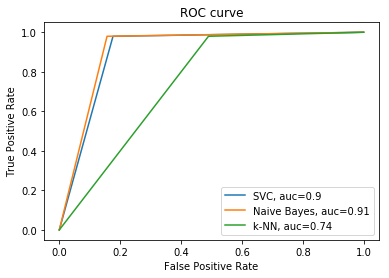

In [17]:
#ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr_svc, tpr_svc, _ = roc_curve(test_labels, pred_svc)
auc_svc = roc_auc_score(test_labels, pred_svc)
plt.plot(fpr_svc,tpr_svc,label="SVC, auc="+str(np.round(auc_svc, 2)))
fpr_bnb, tpr_bnb, _ = roc_curve(test_labels, pred_bnb)
auc_bnb = roc_auc_score(test_labels, pred_bnb)
plt.plot(fpr_bnb,tpr_bnb,label="Naive Bayes, auc="+str(np.round(auc_bnb,2)))
fpr_knn, tpr_knn, _ = roc_curve(test_labels, pred_knn)
auc_knn = roc_auc_score(test_labels, pred_knn)
plt.plot(fpr_knn,tpr_knn,label="k-NN, auc="+str(np.round(auc_knn, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()

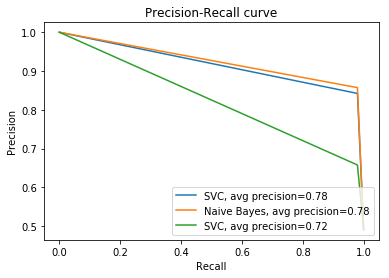

In [18]:
#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_svc, recall_svc, _ = precision_recall_curve(test_labels, pred_svc)
plt.plot(recall_svc, precision_svc, label="SVC, avg precision="+str(np.round(np.mean(precision_svc),2)))
precision_bnb, recall_bnb, _ = precision_recall_curve(test_labels, pred_bnb)
plt.plot(recall_bnb, precision_bnb, label="Naive Bayes, avg precision="+str(np.round(np.mean(precision_bnb),2)))
precision_knn, recall_knn, _ = precision_recall_curve(test_labels, pred_knn)
plt.plot(recall_knn, precision_knn, label="SVC, avg precision="+str(np.round(np.mean(precision_knn),2)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc=4)
plt.show()

In order to overcome the issue of not learned words in the test data, my approach is to simply remove and ignore them. I use transform() function to transforms the "test data" into document-term matrix and disregard the unseen words in training data. My assumption is that the unseen words are words that are not prevalent in the email since they do not occur in the larger training data. Therefore, removing them should not have much influence on the model performance in terms of classifying spam emails and ham emails.

In this case, we should use the ROC curve for evaluation since the negative class(ham) is much fewer than the positive class(spam). By identifying the false positive rate(FP/TN+FP), we can assess whether the classifier is good or not.

From the ROC curve, we can see that the Bernoulli Naive Bayes is the best model, which reaches the highest True Positive Rate with lowest False Positive Rate.

# Part 2: Image Segmentation [50 points]

### What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

### Prerequisites [20 points]

You get 20 points for setting up AWS and successfully running the code given in the following sections.

This homework needs to be run on an AWS GPU instance; it will not complete in time without a GPU. Look up the relevant documentation to set up an AWS machine as configured below; the same machine may be "stopped" (not "terminated") and then resumed for use in the final exam.

**Machine.**

   - Use the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Use a p2.xlarge instance.
   - Allocate at least 80GB of disk space.
   - Use the `conda_tensorflow_p36` Conda environment: `source activate tensorflow_p36`
   - Create a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: `pip install cython`
   * Install Tensorflow: `pip install tensorflow==1.3.0 tensorflow-gpu==1.3.0`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

### Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

Make sure you understand the annotations and how they are connect to images by looking at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

### Set up the environment

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

### Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

### Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [ ]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

### Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Load and visualize a random image

Make sure you understand what the code below is doing.

In [ ]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

### Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

In [ ]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

### Load the data

Load the annotations for the training images into memory.

In [ ]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

Now load the same for the test images.

In [ ]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

### List a few object classes

In [ ]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

### Visualize a random image and its annotations

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Training configuration

See the default configuration values in `config.py`.

In [ ]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()

### Create a new model in training mode [5 points]

In [ ]:
# Create model in training mode

### Initialize the model weights with the weights learned on COCO [5 points]

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [ ]:
# your code here

### Train the model for 10 epochs [5 points]

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [ ]:
%%time
# call to train

### Visualize learning progress with TensorBoard [5 points]

   - Start Tensorboard with `tensorboard --logdir=logs/` in the same folder as the notebook:
```
TensorBoard 0.1.8 at http://ip-172-31-27-18:6006 (Press CTRL+C to quit)
```

   - Connect to `public_dns:6006` where `public_dns` is your public DNS.
   - Click on the "Scalars" tab at the top of the page.
   - Include a screenshot of the overall loss vs. number of epochs below this line (store the image in the same folder as the notebook as "yourloss.png".
   
 <img src="yourloss.png"/>

### Test model [10 points]

Load the model in inference (testing) mode.

In [ ]:
# load model

Load the last trained model weights.

In [ ]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

In [ ]:
# prediction function call and visualization

# Part 3: Sentiment Analysis [50 points]

Download data from: https://www.dropbox.com/s/ouhiwmzodc4baob/HW3-data-Sentiment.zip?dl=0 <br>

The folder contains:

- Train.csv
- test.csv

### Read the training data  [5 Points]

Read the data present in training.csv file. **Please do no change the file name and use relative path, i.e. './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the Sentiment and sentiment text in the dataframe - the first and the last coumn
2. Some of the sentiments and sentiment texts are empty. Remove those rows.
3. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
4. Print the first 5 sentiments.
5. Print the number of positive and negative sentiments

In [27]:
os.getcwd()
os.chdir('/Users/michellehsu/Desktop/CMU/Spring 2018/Mini 4/95-865 Unstructured Data Analytics/HW/HW 3 -Classification, Image Segmentation and Sentiment Analysis/HW3-data')
import numpy as np
import pandas as pd

In [41]:
train = pd.read_csv('train.csv', encoding='latin-1', header = None)

In [42]:
train.drop([1, 2, 3, 4], axis = 1, inplace = True)
train.dropna(inplace = True)
train.columns = ["sentiment", "text"]

In [43]:
#shuffle the dataframe
train = train.iloc[np.random.permutation(len(train))]

In [44]:
train.head(5)

,sentiment,text
1463044,1,@MalinBerdette Sweetie! yeah it was super &amp...
77545,0,I cant believe she did that
940731,1,@Eli_Lama We live on the Mainland of a very l...
1130098,1,little studyin than jumpin to bed yeahh I spe...
221371,0,"2:45 am, heard a cat being attacked by dogs, w..."


In [49]:
train.groupby(by = 'sentiment').agg({'sentiment':'count'})

,sentiment
sentiment,
0,800000
1,800000


### Data Preparation [10 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (twitters), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the dataframe, and convert them to a list of strings, where each string is a tweet. [1 pt]

In [192]:
raw = train['text'][0:5000].tolist()

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [60]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [193]:
tokenizer = Tokenizer(num_words= 10000)
tokenizer.fit_on_texts(raw)
token_seq = tokenizer.texts_to_sequences(raw)

3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [194]:
from keras.preprocessing import sequence
token_seq = sequence.pad_sequences(token_seq, maxlen=120)

4\. Split the above data (the sequence and the label) into training (67%) and validation (33%) sets. [3 pts]

In [195]:
label = train['sentiment'][0:5000].tolist()

In [196]:
X_train = token_seq[0:int(len(token_seq)*0.67)]
X_val = token_seq[int(len(token_seq)*0.67):]
y_train = label[0:int(len(token_seq)*0.67)]
y_val = label[int(len(token_seq)*0.67):]

In [197]:
#The same data preprocess for test data
test = pd.read_csv('test.csv', encoding='latin-1', header = None)
test.drop([1, 2, 3, 4], axis = 1, inplace = True)
test.columns = ["sentiment", "text"]
raw_test = test['text'][0:5000].tolist()
tokenizer_test = Tokenizer(num_words= 10000)
tokenizer_test.fit_on_texts(raw_test)
token_seq_test = tokenizer_test.texts_to_sequences(raw_test)
x_test = sequence.pad_sequences(token_seq_test, maxlen=120)
y_test = np.array(test['sentiment'])

###  RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [198]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN
model_simple = Sequential()
model_simple.add(Embedding(10000, 64))
model_simple.add(SimpleRNN(64))
model_simple.add(Dense(1, activation='sigmoid'))
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [199]:
model_simple.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

2\. Fit the model with the training set with 5 epochs and batch size 32.

In [200]:
history_simple = model_simple.fit(X_train, y_train,epochs=5,batch_size=32, validation_data = (X_val, y_val))

Train on 3350 samples, validate on 1650 samples
Epoch 1/5
3350/3350 [==============================] - 5s 1ms/step - loss: 0.6892 - acc: 0.5463 - val_loss: 0.6715 - val_acc: 0.5806
Epoch 2/5
3350/3350 [==============================] - 4s 1ms/step - loss: 0.5248 - acc: 0.7791 - val_loss: 0.6315 - val_acc: 0.6273
Epoch 3/5
3350/3350 [==============================] - 4s 1ms/step - loss: 0.3652 - acc: 0.8439 - val_loss: 0.7009 - val_acc: 0.6279
Epoch 4/5
3350/3350 [==============================] - 4s 1ms/step - loss: 0.1560 - acc: 0.9487 - val_loss: 0.8003 - val_acc: 0.6218
Epoch 5/5
3350/3350 [==============================] - 4s 1ms/step - loss: 0.0561 - acc: 0.9866 - val_loss: 1.0513 - val_acc: 0.6048


3\. Plot the training and validation accuracy for each epoch.

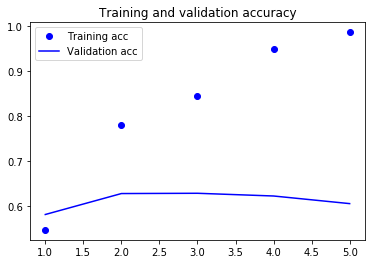

In [201]:
import matplotlib.pyplot as plt
acc_simple = history_simple.history['acc']
val_acc_simple = history_simple.history['val_acc']
epochs = range(1, len(acc_simple) + 1)
plt.plot(epochs, acc_simple, 'bo', label='Training acc')
plt.plot(epochs, val_acc_simple, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [202]:
test_loss_simple, test_acc_simple = model_simple.evaluate(x_test, y_test)
print('Test accuracy with simpleRNN:', test_acc_simple)

498/498 [==============================] - 0s 366us/step
Test accuracy with simpleRNN: 0.536144578074


### LSTM [10 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [204]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
model_LSTM = Sequential()
model_LSTM.add(Embedding(10000, 64))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy for each epoch.

Train on 3350 samples, validate on 1650 samples
Epoch 1/5
3350/3350 [==============================] - 13s 4ms/step - loss: 0.6704 - acc: 0.5893 - val_loss: 0.6179 - val_acc: 0.6824
Epoch 2/5
3350/3350 [==============================] - 12s 4ms/step - loss: 0.5274 - acc: 0.7621 - val_loss: 0.5710 - val_acc: 0.6939
Epoch 3/5
3350/3350 [==============================] - 12s 4ms/step - loss: 0.3886 - acc: 0.8334 - val_loss: 0.6002 - val_acc: 0.7048
Epoch 4/5
3350/3350 [==============================] - 13s 4ms/step - loss: 0.2995 - acc: 0.8776 - val_loss: 0.6218 - val_acc: 0.7073
Epoch 5/5
3350/3350 [==============================] - 12s 4ms/step - loss: 0.2171 - acc: 0.9170 - val_loss: 0.6427 - val_acc: 0.7085


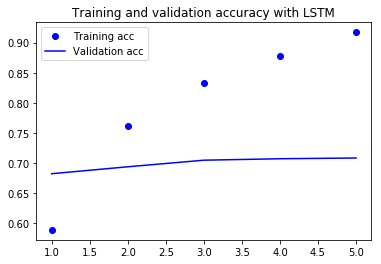

In [205]:
model_LSTM.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32, validation_data = (X_val, y_val))

import matplotlib.pyplot as plt
acc_LSTM = history_LSTM.history['acc']
val_acc_LSTM = history_LSTM.history['val_acc']
epochs = range(1, len(acc_LSTM) + 1)
plt.plot(epochs, acc_LSTM, 'bo', label='Training acc')
plt.plot(epochs, val_acc_LSTM, 'b', label='Validation acc')
plt.title('Training and validation accuracy with LSTM')
plt.legend()
plt.show()

In [206]:
test_loss_LSTM, test_acc_LSTM = model_LSTM.evaluate(x_test, y_test)
print('Test accuracy with LSTM:', test_acc_LSTM)

498/498 [==============================] - 0s 747us/step
Test accuracy with LSTM: 0.568273092489


iii) [6 points] In the previous models, we only use the top 5000 tweets. Now use the whole dataset, split it into training (67%) and validation (33%) set, and train the same LSTM model on the new traning data. plot the training and validation accuracy for each epoch.

In [207]:
text = train['text'].tolist()
tokenizer_all = Tokenizer(num_words= 10000)
tokenizer_all.fit_on_texts(text)
token_seq_all = tokenizer_all.texts_to_sequences(text)
token_seq_all = sequence.pad_sequences(token_seq_all, maxlen=120)

In [208]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(token_seq_all, np.array(train['sentiment']), test_size=0.33, shuffle = True)

In [209]:
history = model_LSTM.fit(X_train, y_train, epochs= 3, batch_size= 1200, validation_data = (X_val, y_val))

Train on 1072000 samples, validate on 528000 samples
Epoch 1/3
1072000/1072000 [==============================] - 1753s 2ms/step - loss: 0.4595 - acc: 0.7824 - val_loss: 0.4240 - val_acc: 0.8049
Epoch 2/3
1072000/1072000 [==============================] - 1736s 2ms/step - loss: 0.4026 - acc: 0.8163 - val_loss: 0.4043 - val_acc: 0.8148
Epoch 3/3
1072000/1072000 [==============================] - 1751s 2ms/step - loss: 0.3892 - acc: 0.8240 - val_loss: 0.3971 - val_acc: 0.8203


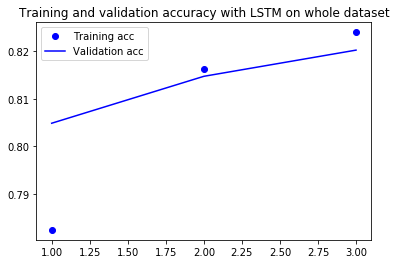

In [210]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy with LSTM on whole dataset')
plt.legend()
plt.show()

### Results Comparision [5 points]

1\. [2 points] Compare the simple RNN model and the LSTM model (trained on the 5000 tweets sample). Which one has a better performance? Why does this one outperform the other one?

From the graph above, we can see that the validation accuracy of LSTM is higher than the accuracy of simple RNN. Therefore, LSTM outperformes simple RNN since LSTM will keep track of long-term memory while training the neural net. 

2\. [3 points] Compare the LSTM model trained on a 5000 tweets sample and the one trained on the whole dataset. What are the cost and the benefit of each case?

The performance of LSTM using the whole dataset is better than just using 5000 tweets samples. The validation accuracy of whole dataset is further boosted over 0.80 compared to only using 5000 tweets. However, the computation time of using the whole dataset is also much longer than just using the subset of data.<br> In sum, the benefit of using the whole dataset is that the performance can be increased and the cost is computational expensive.